In [27]:
import pickle
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit import  QuantumCircuit, transpile
import random

In [28]:
# n_qubits = 5

# baseline_dirs = [f'{n_qubits}', f'{n_qubits}_app',]
# quct_dirs = [f'{n_qubits}_test/result', '5_app/result']
# n_neighbors = 7

In [29]:
n_qubits = 4

baseline_dirs = [f'{n_qubits}', ]
quct_dirs = [f'5_app/result',]
n_neighbors = 10 # 后面加到判断里面

In [30]:
linear = True

In [31]:
baseline_results = []

dir_files = []

for baseline_dir in baseline_dirs:
    for dirpath, dirnames, filenames in os.walk(baseline_dir):
        for filename in filenames:
            if 'json' not in filename or 'pkl' in filename:
                continue

            if (linear and 'linear' not in filename) or (not linear and 'linear' in filename):
                continue

            print(filename)
            with open(os.path.join(dirpath, filename), mode='r') as f:
                result_dict = json.load(f)
            baseline_results.append(result_dict)


for result_dict in baseline_results:
    picked_unitary = json.loads(result_dict['Unitary']).encode('latin-1')
    U = pickle.loads(picked_unitary)
    result_dict['U'] = U

linear-random-4-9.json
linear-random-4-4.json
linear-random-4-2.json
linear-random-4-8.json
linear-random-4-3.json
linear-random-4-0.json
linear-random-4-1.json
linear-random-4-7.json
linear-random-4-6.json
linear-random-4-5.json


In [32]:
baseline_results[0].keys(), baseline_results[0]['Metrics'][0].keys()

(dict_keys(['Experiment Name', 'Unitary', 'Num of Qubits', 'Metrics', 'U']),
 dict_keys(['Synthesiser', 'Circuit', 'Execution Time', 'CNOT Count', 'Depth', 'Parallelism', 'CPU time', 'gate_num']))

In [33]:
synthesized_filenames = []
results = []

for quct_dir in quct_dirs:
    for dirpath, dirnames, filenames in os.walk(quct_dir):
        for filename in filenames:
            if 'pkl' not in filename or f'-{n_qubits}-' not in filename:  # 'change_func' not in filename or
                continue
            
            if (linear and 'linear' not in filename) or (not linear and 'linear' in filename):
                continue

            print(filename)
            with open(os.path.join(dirpath, filename), mode='rb') as f:
                result_dict = pickle.load(f)
            
            result_dict['baseline_name'] =  filename.split('_')[2]
            results.append(result_dict)
        

True_5_linear-random-4-4.json_2_10.pkl
True_5_linear-random-4-9.json_2_10.pkl
True_5_linear-random-4-2.json_2_10.pkl
True_5_linear-random-4-1.json_2_10.pkl
True_5_linear-random-4-6.json_2_10.pkl
True_5_linear-random-4-0.json_2_10.pkl
True_5_linear-random-4-3.json_2_10.pkl
True_5_linear-random-4-8.json_2_10.pkl
True_5_linear-random-4-5.json_2_10.pkl
True_5_linear-random-4-7.json_2_10.pkl


In [34]:
results[0].keys()

dict_keys(['n_qubits', 'U', 'qiskit circuit', '#gate', '#two-qubit gate', 'depth', 'cpu time', 'use heuristic', 'n_unitary_candidates', 'baseline_name', 'baseline_dir', 'n_neighbors', 'print', 'heuristic_takeeffect_count', 'heuristic_takeeffect_prob', 'iter_count', 'synthesis_time'])

In [35]:
merge_results = []
for quct_result in results:
    U = quct_result['U']

    corr_baseline_result = None
    for baseline_result in baseline_results:
        # print(baseline_result['U'].shape[0],  2**n_qubits, U.shape)
        if baseline_result['U'].shape[0] !=  2**n_qubits or np.allclose(U, baseline_result['U']):
            corr_baseline_result = baseline_result
            break
    
    if corr_baseline_result is None:
        print('don find')
        continue

    merge_result = {
        'U': U,
        'filename': quct_result['baseline_name'],
        'cpu_time': {},
        'time': {},
        '#two-qubit': {},
        '#gate': {},
        'depth': {},
    }

    # dict_keys(['n_qubits', 'U', 'qiskit circuit', '#gate', '#two-qubit gate', 'depth', 'cpu time', 'use heuristic', 'n_unitary_candidates', 'n_neighbors', 'print', 'heuristic_takeeffect_count', 
    # 'heuristic_takeeffect_prob', 'iter_count', 'synthesis_time'])

    merge_result['#two-qubit']['quct'] = quct_result['#two-qubit gate']
    merge_result['time']['quct'] = quct_result['synthesis_time']
    merge_result['#gate']['quct'] = quct_result['#gate']
    merge_result['depth']['quct'] = quct_result['depth']
    merge_result['cpu_time']['quct'] = quct_result['cpu time']

    # (dict_keys(['Experiment Name', 'Unitary', 'Num of Qubits', 'Metrics', 'U']),
    # dict_keys(['Synthesiser', 'Circuit', 'Execution Time', 'CNOT Count', 'Depth', 'Parallelism', 'CPU time', 'gate_num']))
        # baseline_name = metric['Synthesiser']
    for metric in corr_baseline_result['Metrics']:
        baseline_name = metric['Synthesiser'].replace(' Synthesiser', '').replace(' synthesiser', '')
        # print(baseline_name, metric)
        # print(metric.keys(), baseline_name)
        qiskit_circuit = QuantumCircuit.from_qasm_str(metric['Circuit'])
        if 'QFast' in baseline_name:
            qiskit_circuit = transpile(qiskit_circuit, optimization_level=3, basis_gates=['u', 'cz'])

        merge_result['#two-qubit'][baseline_name] = metric['CNOT Count']
        merge_result['time'][baseline_name] = metric['Execution Time']
        merge_result['#gate'][baseline_name] = len(qiskit_circuit)#metric['gate_num']
        merge_result['depth'][baseline_name] = qiskit_circuit.depth()

        '''为什么会有没有的'''
        merge_result['cpu_time'][baseline_name] = metric.get('CPU time', metric['Execution Time'] )
        if 'QFast' in baseline_name:
            merge_result['cpu_time'][baseline_name] *= 7
            if n_qubits == 4:
                merge_result['cpu_time'][baseline_name] *= 7
                merge_result['time'][baseline_name] *= 7
    
    merge_results.append(merge_result)
    

In [36]:
merge_results[0]

{'U': array([[-1.71473357e-01-3.74904089e-02j,  3.00309212e-01+1.13358886e-01j,
          1.70926341e-01+6.02559878e-02j,  1.17195781e-02-2.90204109e-02j,
         -2.69320759e-03-3.72022371e-01j,  1.52358962e-01-2.46534358e-01j,
          9.85961616e-02-1.35236908e-01j, -6.63606134e-02-1.11120385e-01j,
         -1.11794733e-01-1.14319714e-01j,  1.62272602e-01-7.00259136e-02j,
          1.10739468e-01-2.72098161e-04j, -6.84432380e-02+1.83280162e-01j,
          3.01475903e-01-2.67800394e-01j, -1.03912004e-01+5.07531457e-02j,
         -3.99028454e-01-1.42650013e-02j, -7.57704807e-02-3.41581799e-01j],
        [ 7.85882380e-02-3.71037720e-01j, -2.21322469e-01+9.51063833e-03j,
         -1.66056124e-01-7.05513823e-02j,  1.60245449e-01+9.59334085e-02j,
         -5.11435149e-02+6.43661732e-02j, -8.84603552e-02+1.15106066e-01j,
          2.29963089e-01+2.57454107e-01j,  1.46773153e-01+6.48342965e-02j,
         -8.17398271e-02-2.10013971e-01j, -1.32873063e-01+1.22967889e-01j,
          3.0747379

In [37]:
merge_results = []
for quct_result in results:
    U = quct_result['U']

    corr_baseline_result = None
    for baseline_result in baseline_results:
        # print(baseline_result['U'].shape[0],  2**n_qubits, U.shape)
        if baseline_result['U'].shape[0] !=  2**n_qubits or np.allclose(U, baseline_result['U']):
            corr_baseline_result = baseline_result
            break
    
    if corr_baseline_result is None:
        print('don find')
        continue

    merge_result = {
        'U': U,
        'filename': quct_result['baseline_name'],
        'cpu_time': {},
        'time': {},
        '#two-qubit': {},
        '#gate': {},
        'depth': {},
    }

    # dict_keys(['n_qubits', 'U', 'qiskit circuit', '#gate', '#two-qubit gate', 'depth', 'cpu time', 'use heuristic', 'n_unitary_candidates', 'n_neighbors', 'print', 'heuristic_takeeffect_count', 
    # 'heuristic_takeeffect_prob', 'iter_count', 'synthesis_time'])

    merge_result['#two-qubit']['quct'] = quct_result['#two-qubit gate']
    merge_result['time']['quct'] = quct_result['synthesis_time']
    merge_result['#gate']['quct'] = quct_result['#gate']
    merge_result['depth']['quct'] = quct_result['depth']
    merge_result['cpu_time']['quct'] = quct_result['cpu time']

    if linear:
        merge_result['time']['quct'] /= 3
        merge_result['cpu_time']['quct'] /= 3

    # (dict_keys(['Experiment Name', 'Unitary', 'Num of Qubits', 'Metrics', 'U']),
    # dict_keys(['Synthesiser', 'Circuit', 'Execution Time', 'CNOT Count', 'Depth', 'Parallelism', 'CPU time', 'gate_num']))
        # baseline_name = metric['Synthesiser']
    for metric in corr_baseline_result['Metrics']:
        baseline_name = metric['Synthesiser'].replace(' Synthesiser', '').replace(' synthesiser', '')
        # print(baseline_name, metric)
        # print(metric.keys(), baseline_name)
        qiskit_circuit = QuantumCircuit.from_qasm_str(metric['Circuit'])
        if 'QFast' in baseline_name:
            qiskit_circuit = transpile(qiskit_circuit, optimization_level=3, basis_gates=['u', 'cz'])

        merge_result['#two-qubit'][baseline_name] = metric['CNOT Count']
        merge_result['time'][baseline_name] = metric['Execution Time']
        merge_result['#gate'][baseline_name] = len(qiskit_circuit)#metric['gate_num']
        merge_result['depth'][baseline_name] = qiskit_circuit.depth()

        '''为什么会有没有的'''
        merge_result['cpu_time'][baseline_name] = metric.get('CPU time', metric['Execution Time'] )
        if 'QFast' in baseline_name:
            merge_result['cpu_time'][baseline_name] *= 7
            if n_qubits == 4:
                merge_result['cpu_time'][baseline_name] *= 7
                merge_result['time'][baseline_name] *= 7


    merge_results.append(merge_result)
    

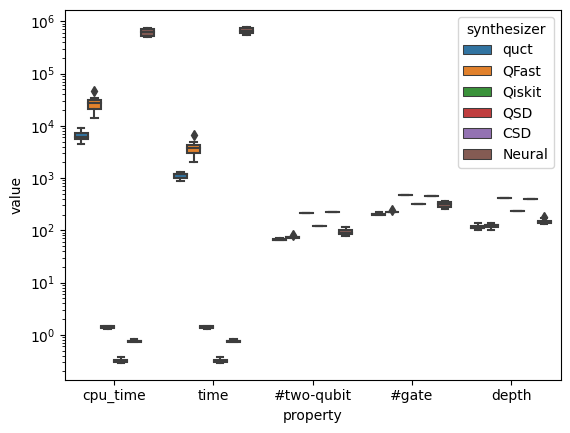

In [38]:
ax = sns.boxplot(x="property", y="value", hue="synthesizer", data=all_result_df)  # RUN PLOT  
ax.set_yscale('log')

In [39]:
for prop_name in ['#two-qubit', 'time', '#gate', 'depth', 'cpu_time']:
    prop_df = all_result_df[all_result_df['property'] == prop_name]

    qfast_df =  np.array(prop_df[prop_df['synthesizer'] == 'QFast']['value'])
    quct =  np.array(prop_df[prop_df['synthesizer'] == 'quct']['value'])

    quct = quct[:len(qfast_df)]
    print(prop_name, float(qfast_df.mean() / quct.mean()),  float(quct.mean() / qfast_df.mean()))
    # print(prop_name, float((qfast_df / quct).mean()),  float( (quct / qfast_df).mean()))

'''似乎还会有qfast没有quct有的'''

#two-qubit 1.116591928251121 0.8955823293172691
time 3.4528085486636018 0.28961930147764686
#gate 1.1143136297020029 0.8974134151687856
depth 1.0607638888888888 0.9427168576104746
cpu_time 4.206164402733023 0.2377462943080004


'似乎还会有qfast没有quct有的'

In [40]:
len(quct)

10

In [41]:
len(qfast_df)

10

In [42]:
qfast_df =  prop_df[prop_df['synthesizer'] == 'QFast']
qfast_df.mean()

/tmp/ipykernel_3615889/569752527.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  qfast_df.mean()


value    27196.996514
dtype: float64

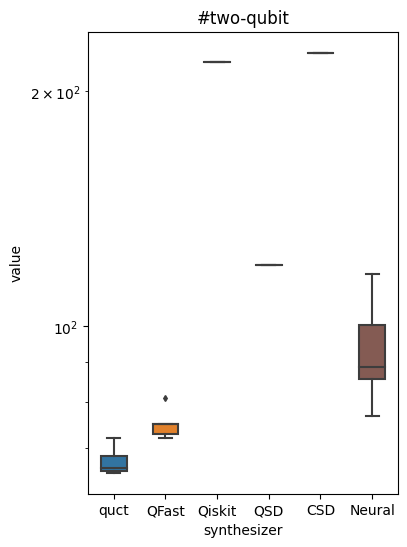

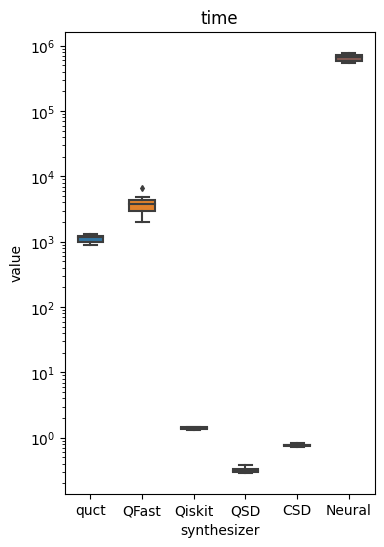

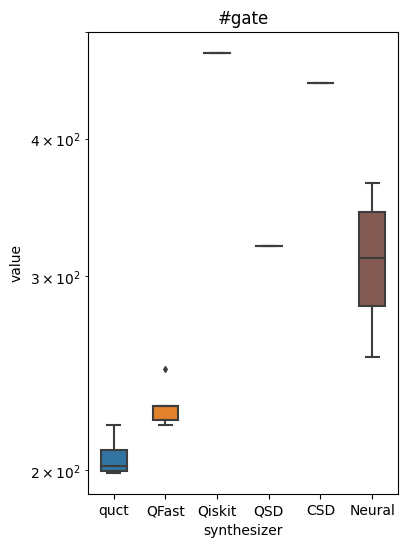

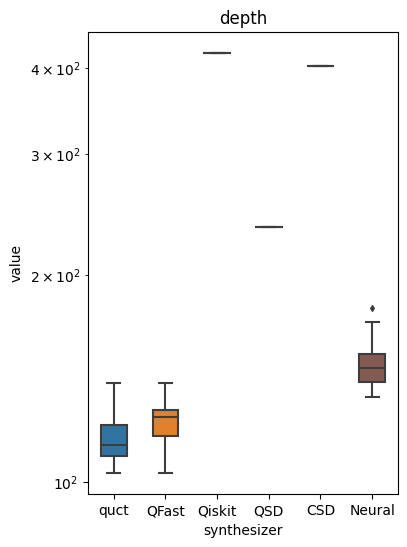

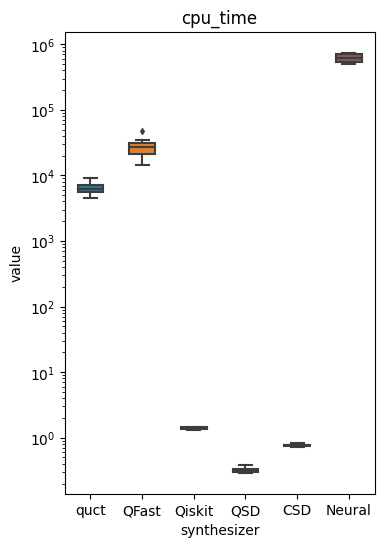

In [45]:
for prop_name in ['#two-qubit', 'time', '#gate', 'depth', 'cpu_time']:
    fig, ax = plt.subplots(figsize =(4,6))

    plot_data = all_result_df[all_result_df['property'] == prop_name]
    ax = sns.boxplot(x="synthesizer", y="value", data=plot_data, fliersize=3, width =.5)  # RUN PLOT
    plt.title(prop_name)
    ax.set_yscale('log')
    fig.show()
    fig.savefig(f'synthesis_evaluation_fig/qubit{n_qubits}_{prop_name}_{"linear" if linear else ""}.svg')

   Trial Number     value
0      1      1 -0.750615
1      1      1 -1.715070
2      1      1 -0.963404
3      1      1  0.360856
4      1      1 -1.190504


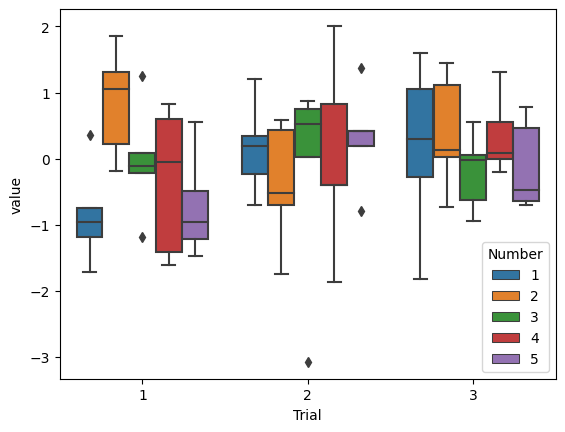

In [44]:
np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED
df1 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=1)
df2 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=2)
df3 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=3)

cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Number'])      # MELT

print(mdf.head())
#    Trial Number     value
# 0      1      1 -0.750615
# 1      1      1 -1.715070
# 2      1      1 -0.963404
# 3      1      1  0.360856
# 4      1      1 -1.190504

ax = sns.boxplot(x="Trial", y="value", hue="Number", data=mdf)  # RUN PLOT  
plt.show()

plt.clf()
plt.close()